In [1]:
import numpy as np
from nm_lib import nm_lib as nm
import threading

from scipy.interpolate import interp1d

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from matplotlib import animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Operator splitting 

## 1- OS precision

Solve the following Burgers' equation: 

$$\frac{\partial u}{\partial t} = - a \frac{\partial u}{\partial x} - b \frac{\partial u}{\partial x}   \tag{1}$$

following exersize [2b](https://github.com/AST-Course/AST5110/blob/main/ex_2b.ipynb). where $x[x_0, x_f]$ with $x_0 = −2.6$, $x_f = 2.6$, $a=-0.7$ and $b=-0.3$, periodic boundary conditions and with initial condition:

$$u(x,t=t_0) = \cos^2 \left(\frac{6 \pi x}{5} \right) / \cosh(5x^2)  \tag{2}$$

Solve the evolution for the following four different approaches: 

- 1 With additive OS.  

- 2 With Lie-Trotter OS. 

- 3 With Strang OS.

- 4 Without an operator splitting and single time-step method but add the to terms: 

$$\frac{\partial u}{\partial t} = - (a+b) \frac{\partial u}{\partial x}$$

for $nump=256$ and 100 steps.

_Suggestion_: use the Lax-method scheme for all cases with `deriv_cent`. Make sure the boundaries are properly selected.

Fill in the function `osp_LL_Add`, `osp_LL_Lie`, and `osp_LL_Strang`.

Start with $cfl\_cut = 0.4$ and increase up to $0.9$.  

Which OS schemes are stable? Which one is more diffusive? Why?

In [3]:
def u(x):
    return (np.cos(6*np.pi*x/5))**2 / np.cosh(5*x*x)

In [4]:
x0 = -2.6
xf = 2.6
#number of x-points
nump = 256
#number of t-points
nt = 150
#xgrid
xx = np.arange(nump)/(nump-1.0) * (xf-x0) + x0
hh = u(xx)

a = -0.7
b = -0.3

In [ ]:
#Calling all OS functions and Lax and then interpolating so I can look at the same time points in animation
cut_04 = {}

tt, unnt = nm.ops_Lax_LL_Add(xx, hh, nt, a, b, cfl_cut = 0.4)
cut_04["Add"] = {"tt":tt, "unnt":unnt}

tt, unnt = nm.ops_Lax_LL_Lie(xx, hh, nt, a, b, cfl_cut = 0.4)
cut_04["Lie"] = {"tt":tt, "unnt":unnt}

tt, unnt = nm.ops_Lax_LL_Strang(xx, hh, nt, a, b, cfl_cut = 0.4)
cut_04["Strang"] = {"tt":tt, "unnt":unnt}

tt, unnt = nm.evolv_Lax_adv_burgers(xx, hh, nt, a+b, cfl_cut = 0.4)
cut_04["Lax"] = {"tt":tt, "unnt":unnt}

for key in cut_04:
    method = cut_04[key]
    interp_func = interp1d(method["tt"], method["unnt"], axis=0)
    cut_04[key]["interpolation"] = interp_func

In [ ]:
def plot(ax, fig, index, methods):
    ### Plots interpolated function of time
    keys = list(methods.keys())
    time = np.min([methods[key]["tt"][index] for key in keys])
    for j in range(len(keys)):
        func = methods[keys[j]]["interpolation"](time)
        ax.plot(xx, func, label="{:s}".format(keys[j]))
    
    ax.set_title("t={:.2f}".format(time))
    ax.grid(True)
    ax.legend(loc='upper right')
    ax.set_ylim(-0.05, 1.05)  

In [ ]:
fig, ax = plt.subplots(nrows=1, figsize=(10, 5))
def init():
    plot(ax, fig, 0, cut_04)

def animate(i):
    ax.clear()
    plot(ax, fig, i, cut_04)
    
anim = FuncAnimation(fig, animate, interval=50, frames=nt, init_func=init)
HTML(anim.to_jshtml())

From this plot we observe that from most diffusive to least diffusive we have: Strang, Lax, Lie, Add. But Add is very unstable and blows up.

In [ ]:
cut_09 = {}

tt, unnt = nm.ops_Lax_LL_Add(xx, hh, nt, a, b, cfl_cut = 0.9)
cut_09["Add"] = {"tt":tt, "unnt":unnt}

tt, unnt = nm.ops_Lax_LL_Lie(xx, hh, nt, a, b, cfl_cut = 0.9)
cut_09["Lie"] = {"tt":tt, "unnt":unnt}

tt, unnt = nm.ops_Lax_LL_Strang(xx, hh, nt, a, b, cfl_cut = 0.9)
cut_09["Strang"] = {"tt":tt, "unnt":unnt}

tt, unnt = nm.evolv_Lax_adv_burgers(xx, hh, nt, a+b, cfl_cut = 0.9)
cut_09["Lax"] = {"tt":tt, "unnt":unnt}

for key in cut_09:
    method = cut_09[key]
    interp_func = interp1d(method["tt"], method["unnt"], axis=0)
    cut_09[key]["interpolation"] = interp_func

In [ ]:
fig, ax = plt.subplots(nrows=1, figsize=(10, 5))
def init():
    plot(ax, fig, 0, cut_09)

def animate(i):
    ax.clear()
    plot(ax, fig, i, cut_09)
    
anim = FuncAnimation(fig, animate, interval=50, frames=nt, init_func=init)
HTML(anim.to_jshtml())

Here we see Lax and Lie have little diffusion but still Strang has a lot. And Add blows up again. And for some reason for both plots the velocities don't match up even if they are evaluated at the same timestep. And I have interpolated the solutions so I can look at them at the same time.

## 2- When does it not work? 

Use OS-Strang from the previous exercise and try to apply a predictor-corrector explicit method. 
To facilitate this exercise, `nm_lib` already includes the predictor-corrector Hyman method, which is included Bifrost (`Hyman`). Fill in the function `osp_Lax_LH_Strang`. Use the same setup as the previous exercise but with $nump=512$, $500$ steps, and $cfl\_cut=0.8$. 

What do you notice? 

__Optional__: Apply the Hyman predictor-corrector explicit method to the Burgers equation and check if the following is true: 

$$u^{n+1} = F\, u^{n}\Delta t \approx G\, u^{n}\Delta t+H\, u^{n}\Delta t$$

In [10]:
nt = 500

x0 = -2.6
xf = 2.6
#number of x-points
nump = 512
#number of t-points
nt = 150
#xgrid
xx = np.arange(nump)/(nump-1.0) * (xf-x0) + x0
hh = u(xx)

tt, unnt = nm.osp_Lax_LH_Strang(xx, hh, nt, a, b, cfl_cut=0.8)

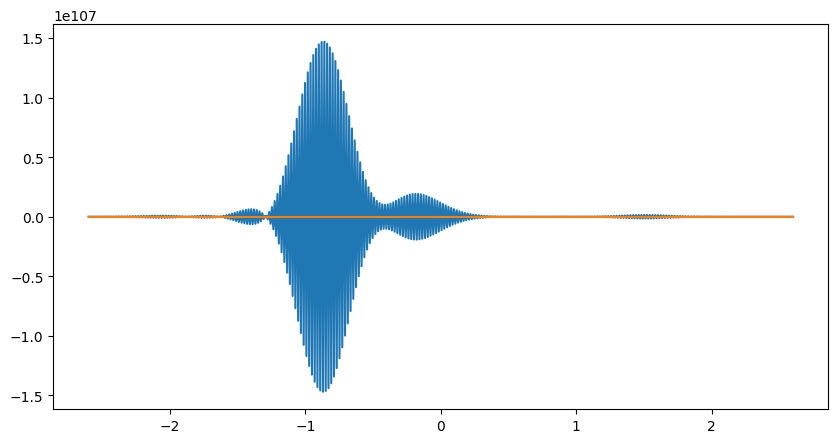

In [11]:
fig, ax = plt.subplots(nrows=1, figsize=(10, 5))
def init():
    ax.plot(xx, unnt[0,:])

def animate(i):
    ax.clear()
    ax.plot(xx, unnt[i,:])
    
anim = FuncAnimation(fig, animate, interval=50, frames=nt, init_func=init)
HTML(anim.to_jshtml())